# Jonathan Halverson
# Monday, March 27, 2017
# Part 13: Simple predictive models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')
from scipy.stats import binom, norm

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)

In [2]:
iofile = 'data/ufc_champions.csv'
champs = pd.read_csv(iofile, header=0, parse_dates=['Date'])
champs = champs.set_index('Name')
champs.head(3)

,Date
Name,
Amanda Nunes,2016-07-12
Anderson Silva,2006-10-17
Andrei Arlovski,2005-02-08


In [3]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


In [176]:
x = 'Ovince Saint Preux'
fights[(fights.Winner == x) | (fights.Loser == x)]

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
13,Volkan Oezdemir,def.,Ovince Saint Preux,Light Heavyweight,S-DEC,NaN,3,5:00,UFC Fight Night: Bermudez vs. The Korean Zombie,2017-02-04,"Houston, Texas, USA",15.000000,0,11,0,7,0.000000,0.636364,3.005119,2.833213,0,0,0.000000,0.571429,0.000000,0.142857,0.0,0.250000,0.0,0.250000,0.000000,0.285714,0.000000,112.583333,0.000000,0.666667
169,Jimi Manuwa,def.,Ovince Saint Preux,Light Heavyweight,KO/TKO,Punch,2,2:38,UFC 204: Bisping vs. Henderson,2016-10-08,"Manchester, England, United Kingdom",7.633333,6,10,4,7,0.666667,0.700000,4.043051,3.178054,0,0,0.750000,0.571429,0.000000,0.142857,1.0,0.000000,0.0,0.333333,0.250000,0.285714,51.450000,104.950000,0.300000,0.666667
403,Jon Jones,def.,Ovince Saint Preux,Light Heavyweight,U-DEC,NaN,5,5:00,UFC 197: Jones vs Saint Preux,2016-04-23,"Las Vegas, Nevada, USA",25.000000,16,9,15,7,0.937500,0.777778,4.219508,2.397895,1,0,0.266667,0.571429,0.333333,0.142857,0.0,0.000000,0.0,0.500000,0.400000,0.285714,215.200000,79.950000,0.961039,0.666667
491,Ovince Saint Preux,def.,Rafael Feijao,Light Heavyweight,U-DEC,NaN,3,5:00,UFC Fight Night: Hendricks vs Thompson,2016-02-06,"Las Vegas, Nevada, USA",15.000000,8,4,6,1,0.750000,0.250000,3.258097,3.295837,0,0,0.666667,1.000000,0.166667,0.000000,0.0,0.666667,0.5,0.000000,0.166667,0.000000,64.950000,31.533333,0.500000,0.000000
691,Glover Teixeira,def.,Ovince Saint Preux,Light Heavyweight,SUB,Rear Naked Choke,3,3:10,UFC Fight Night: Teixeira vs Saint Preux,2015-08-08,"Nashville, Tennessee, USA",13.166667,7,7,5,6,0.714286,0.857143,3.713572,2.772589,0,0,0.400000,0.666667,0.400000,0.166667,0.0,0.000000,0.0,0.000000,0.200000,0.166667,72.433333,51.783333,0.888889,0.500000
882,Ovince Saint Preux,def.,Patrick Cummins,Light Heavyweight,KO/TKO,Punch,1,4:54,UFC Fight Night: Machida vs Rockhold,2015-04-18,"Newark, New Jersey, USA",4.900000,6,4,5,3,0.833333,0.750000,3.135494,2.833213,0,0,0.600000,0.333333,0.200000,0.000000,0.0,1.000000,0.0,0.000000,0.200000,0.666667,46.883333,38.783333,0.636364,0.400000
1081,Ovince Saint Preux,def.,Mauricio Rua,Light Heavyweight,KO/TKO,Punch,1,0:34,UFC Fight Night 56: Shogun vs Saint Preux,2014-11-08,"Uberlandia, Minas Gerais, Brazil",0.566667,5,13,4,6,0.800000,0.461538,2.484907,3.492169,0,1,0.500000,1.000000,0.250000,0.000000,0.0,0.285714,0.0,0.285714,0.250000,0.000000,46.316667,153.400000,0.833333,0.000000
1208,Ryan Bader,def.,Ovince Saint Preux,Light Heavyweight,U-DEC,NaN,5,5:00,UFC Fight Night: Bader vs Saint Preux,2014-08-16,"Bangor, Maine, USA",25.000000,14,4,10,4,0.714286,1.000000,2.197225,2.197225,0,0,0.300000,0.500000,0.100000,0.250000,0.5,0.000000,0.5,0.000000,0.600000,0.250000,127.300000,21.316667,0.586957,0.833333
1297,Ovince Saint Preux,def.,Ryan Jimmo,Light Heavyweight,KO/TKO,NaN,2,2:10,UFC 174: Johnson vs Bagautinov,2014-06-14,"Vancouver, British Columbia, Canada",7.166667,3,5,3,3,1.000000,0.600000,2.564949,2.131627,0,0,0.333333,0.666667,0.333333,0.000000,0.0,0.500000,0.0,0.000000,0.333333,0.333333,14.150000,44.250000,1.000000,0.400000
1421,Ovince Saint Preux,def.,Nikita Krylov,Light Heavyweight,SUB,Other - Choke,1,1:29,UFC 171: Hendricks vs Lawler,2014-03-15,"Dallas, Texas, USA",1.483333,2,2,2,1,1.000000,0.500000,3.401197,1.945910,0,0,0.500000,1.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.500000,0.000000,12.666667,11.983333,0.500000,0.000000


We remove no contests immediately to avoid inf (infinity) in WinRatio, etc. and create new column of fight time:

In [5]:
fights = fights[fights.Outcome != 'no contest']
fights['Minutes'] = 5.0 * (fights.Round - 1) + fights.Time.apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[1]) / 60.0)

In [6]:
# this assumes that the fights dataframe is ordered by date in descending order
# note that "no contests" are ignored which may not make sense for time_since
# for a fighter's first fight we assume they fought around 11-21 weeks ago
num_fights = []
num_fights_L = []
num_wins = []
num_wins_L = []
time_since = []
time_since_L = []
champ = []
champ_L = []
WTKO = []
WTKO_L = []
WSUB = []
WSUB_L = []
WDEC = []
WDEC_L = []
LTKO = []
LTKO_L = []
LSUB = []
LSUB_L = []
total_time = []
total_time_L = []
for index, row in fights.iterrows():
     d = row['Date']
     
     winner = row['Winner']
     x = fights[((fights.Winner == winner) | (fights.Loser == winner)) & (fights.Date < d)]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since.append(np.log(weeks))
          total_time.append(x.Minutes.sum())
     else:
          time_since.append(np.log(norm.rvs(loc=16.0, scale=5.0)))
          total_time.append(0.0)
     num_fights.append(x.shape[0])
     # get number of wins and losses
     y = x[x.Winner == winner]
     l = x[x.Loser == winner]
     num_wins.append(y.shape[0])
     # compute wins by tko and sub
     if (y.shape[0] == 0):
          WTKO.append(0.0)
          WSUB.append(0.0)
          WDEC.append(0.0)
     else:
          WTKO.append(x[(x.Winner == winner) & x.Method.str.contains('KO')].shape[0] / float(y.shape[0]))
          WSUB.append(x[(x.Winner == winner) & x.Method.str.contains('SUB')].shape[0] / float(y.shape[0]))
          WDEC.append(x[(x.Winner == winner) & x.Method.str.contains('DEC|DQ')].shape[0] / float(y.shape[0]))
     if (l.shape[0] == 0):
          LTKO.append(0.0)
          LSUB.append(0.0)
     else:
          LTKO.append(x[(x.Loser == winner) & x.Method.str.contains('KO')].shape[0] / float(l.shape[0]))
          LSUB.append(x[(x.Loser == winner) & x.Method.str.contains('SUB')].shape[0] / float(l.shape[0]))
     # get champion status
     if (winner in champs.index):
          if (row['Date'] > champs.loc[winner].Date):
               champ.append(1)
          else:
               champ.append(0)
     else:
          champ.append(0)
     
     loser = row['Loser']
     x = fights[((fights.Winner == loser) | (fights.Loser == loser)) & (fights.Date < d)]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since_L.append(np.log(weeks))
          total_time_L.append(x.Minutes.sum())
     else:
          time_since_L.append(np.log(norm.rvs(loc=16.0, scale=5.0)))
          total_time_L.append(0.0)
     num_fights_L.append(x.shape[0])
     # get number of wins
     y = x[x.Winner == loser]
     l = x[x.Loser == loser]
     num_wins_L.append(y.shape[0])
     # compute wins by tko and sub
     if (y.shape[0] == 0):
          WTKO_L.append(0.0)
          WSUB_L.append(0.0)
          WDEC_L.append(0.0)
     else:
          WTKO_L.append(x[(x.Winner == loser) & x.Method.str.contains('KO')].shape[0] / float(y.shape[0]))
          WSUB_L.append(x[(x.Winner == loser) & x.Method.str.contains('SUB')].shape[0] / float(y.shape[0]))
          WDEC_L.append(x[(x.Winner == loser) & x.Method.str.contains('DEC|DQ')].shape[0] / float(y.shape[0]))
     if (l.shape[0] == 0):
          LTKO_L.append(0.0)
          LSUB_L.append(0.0)
     else:
          LTKO_L.append(x[(x.Loser == loser) & x.Method.str.contains('KO')].shape[0] / float(l.shape[0]))
          LSUB_L.append(x[(x.Loser == loser) & x.Method.str.contains('SUB')].shape[0] / float(l.shape[0]))
     # get champion status
     if (loser in champs.index):
          if (row['Date'] > champs.loc[loser].Date):
               champ_L.append(1)
          else:
               champ_L.append(0)
     else:
          champ_L.append(0)
fights['NumFights'] = num_fights
fights['NumFights_L'] = num_fights_L
fights['NumWins'] = num_wins
fights['NumWins_L'] = num_wins_L
fights['WinRatio'] = fights.NumWins / fights.NumFights
fights['WinRatio_L'] = fights.NumWins_L / fights.NumFights_L
fights['TimeSince'] = time_since
fights['TimeSince_L'] = time_since_L
fights['Champ'] = champ
fights['Champ_L'] = champ_L
fights['WTKO'] = WTKO
fights['WTKO_L'] = WTKO_L
fights['WSUB'] = WSUB
fights['WSUB_L'] = WSUB_L
fights['LTKO'] = LTKO
fights['LTKO_L'] = LTKO_L
fights['LSUB'] = LSUB
fights['LSUB_L'] = LSUB_L
fights['WDEC'] = WDEC
fights['WDEC_L'] = WDEC_L
fights['total_time'] = total_time
fights['total_time_L'] = total_time_L

/Users/jhalverson/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in log


### Add fighter versitility index

In [7]:
fights['FVI'] = (3 / 2.0) * ((1 / 3.0) / (fights.WTKO**2 + fights.WSUB**2 + fights.WDEC**2) - (1 / 3.0))
fights['FVI_L'] = (3 / 2.0) * ((1 / 3.0) / (fights.WTKO_L**2 + fights.WSUB_L**2 + fights.WDEC_L**2) - (1 / 3.0))

In [8]:
fights.FVI = fights.FVI.replace([np.inf, -np.inf], np.nan)
fights.FVI_L = fights.FVI_L.replace([np.inf, -np.inf], np.nan)
fights.FVI = fights.FVI.fillna(0.0)
fights.FVI_L = fights.FVI_L.fillna(0.0)

### Replace null values

In [9]:
fights.WinRatio = fights.WinRatio.fillna(0.0)
fights.WinRatio_L = fights.WinRatio_L.fillna(0.0)

In [10]:
fights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4067
Data columns (total 36 columns):
Winner          4026 non-null object
Outcome         4026 non-null object
Loser           4026 non-null object
WeightClass     4026 non-null object
Method          4026 non-null object
MethodNotes     2154 non-null object
Round           4026 non-null int64
Time            4026 non-null object
Event           4026 non-null object
Date            4026 non-null datetime64[ns]
Location        4026 non-null object
Minutes         4026 non-null float64
NumFights       4026 non-null int64
NumFights_L     4026 non-null int64
NumWins         4026 non-null int64
NumWins_L       4026 non-null int64
WinRatio        4026 non-null float64
WinRatio_L      4026 non-null float64
TimeSince       4026 non-null float64
TimeSince_L     4025 non-null float64
Champ           4026 non-null int64
Champ_L         4026 non-null int64
WTKO            4026 non-null float64
WTKO_L          4026 non-null float

In [11]:
fights.ix[:,10:].describe().applymap(lambda x: round(x, 2))

,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
count,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4025.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00
mean,9.91,4.43,4.10,2.95,2.61,0.52,0.45,3.06,3.08,0.07,0.05,0.27,0.23,0.17,0.16,0.19,0.19,0.15,0.14,0.29,0.27,44.24,40.42,0.24,0.21
std,6.06,4.61,4.78,3.30,3.30,0.36,0.37,0.58,0.63,0.25,0.21,0.34,0.33,0.29,0.29,0.32,0.33,0.30,0.30,0.35,0.35,51.30,51.00,0.30,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.05,-0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.07,1.00,1.00,0.00,0.00,0.00,0.00,2.74,2.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.72,1.28,0.00,0.00
50%,10.81,3.00,2.00,2.00,1.00,0.60,0.50,3.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,27.68,21.51,0.00,0.00
75%,15.00,7.00,6.00,4.00,4.00,0.79,0.75,3.34,3.37,0.00,0.00,0.50,0.50,0.25,0.25,0.33,0.33,0.00,0.00,0.50,0.50,63.74,57.87,0.48,0.41
max,25.00,26.00,26.00,19.00,19.00,1.00,1.00,6.39,6.36,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,362.82,337.82,1.30,1.00


### Correlation analysis

In [12]:
fights.ix[:,10:].corr().applymap(lambda x: round(x, 2))

,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
Minutes,1.00,0.13,0.09,0.15,0.10,0.10,0.14,0.04,0.03,0.15,0.05,-0.03,0.02,-0.02,0.05,-0.04,-0.04,0.01,-0.06,0.18,0.11,0.20,0.13,0.08,0.11
NumFights,0.13,1.00,0.43,0.96,0.44,0.40,0.30,0.12,0.08,0.34,0.17,0.28,0.22,0.17,0.09,0.27,0.11,0.15,0.07,0.28,0.17,0.94,0.41,0.66,0.34
NumFights_L,0.09,0.43,1.00,0.45,0.96,0.26,0.43,0.08,0.15,0.21,0.37,0.18,0.32,0.04,0.19,0.12,0.27,0.04,0.16,0.15,0.29,0.42,0.94,0.33,0.68
NumWins,0.15,0.96,0.45,1.00,0.47,0.51,0.34,0.08,0.08,0.42,0.21,0.29,0.23,0.16,0.10,0.23,0.10,0.10,0.06,0.29,0.18,0.90,0.43,0.69,0.36
NumWins_L,0.10,0.44,0.96,0.47,1.00,0.30,0.53,0.07,0.12,0.26,0.43,0.19,0.33,0.04,0.19,0.11,0.23,0.03,0.11,0.16,0.30,0.43,0.91,0.35,0.70
WinRatio,0.10,0.40,0.26,0.51,0.30,1.00,0.39,0.11,0.07,0.21,0.15,0.43,0.18,0.29,0.12,0.04,0.05,-0.01,0.03,0.46,0.21,0.36,0.25,0.45,0.25
WinRatio_L,0.14,0.30,0.43,0.34,0.53,0.39,1.00,0.07,0.12,0.19,0.19,0.16,0.46,0.11,0.33,0.06,0.06,0.05,0.04,0.22,0.49,0.29,0.40,0.30,0.48
TimeSince,0.04,0.12,0.08,0.08,0.07,0.11,0.07,1.00,0.11,0.08,0.05,0.07,0.05,0.06,0.01,0.14,0.06,0.06,0.01,0.12,0.07,0.11,0.08,0.07,0.05
TimeSince_L,0.03,0.08,0.15,0.08,0.12,0.07,0.12,0.11,1.00,0.07,0.10,0.06,0.08,0.02,0.08,0.03,0.20,0.05,0.08,0.03,0.10,0.09,0.14,0.06,0.10
Champ,0.15,0.34,0.21,0.42,0.26,0.21,0.19,0.08,0.07,1.00,0.23,0.15,0.13,0.01,0.02,0.12,0.06,0.01,-0.02,0.05,0.06,0.35,0.19,0.22,0.14


In [13]:
sorted(np.unique(np.abs(fights.ix[:,10:].corr().values.ravel())), reverse=True)[:10]

[1.0,
 0.96340532315631044,
 0.96062623016046,
 0.94063594884170509,
 0.93700232226430569,
 0.90802257208344794,
 0.90427150417147228,
 0.69810025539641241,
 0.68705320756965427,
 0.67693256073442754]

In [14]:
fights

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",25.000000,4,5,3,3,0.750000,0.600000,3.685302,3.367296,0,1,0.666667,0.333333,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,0.333333,0.666667,29.733333,84.483333,0.400000,0.400000
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,20,9,16,7,0.800000,0.777778,3.433987,2.397895,1,0,0.687500,0.571429,0.187500,0.142857,0.500000,1.000000,0.000000,0.000000,0.125000,0.285714,194.650000,55.533333,0.455224,0.666667
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",3.683333,7,20,6,11,0.857143,0.550000,3.663562,2.564949,0,0,0.333333,0.545455,0.500000,0.000000,0.000000,0.444444,0.000000,0.333333,0.166667,0.454545,58.083333,187.816667,0.785714,0.491803
3,Glover Teixeira,def.,Jared Cannonier,Light Heavyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,11,3,8,2,0.727273,0.666667,3.218876,2.302585,0,0,0.500000,0.500000,0.375000,0.000000,0.333333,1.000000,0.000000,0.000000,0.125000,0.500000,93.816667,20.683333,0.730769,0.500000
4,Dustin Poirier,def.,Jim Miller,Lightweight,M-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,16,24,12,17,0.750000,0.708333,3.044522,2.564949,0,0,0.416667,0.176471,0.250000,0.352941,0.500000,0.142857,0.250000,0.285714,0.333333,0.470588,128.500000,253.850000,0.940000,0.825688
5,Belal Muhammad,def.,Randy Brown,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,3,4,1,3,0.333333,0.750000,2.564949,2.212973,0,0,1.000000,0.333333,0.000000,0.333333,0.500000,0.000000,0.000000,1.000000,0.000000,0.333333,30.633333,39.233333,0.000000,1.000000
6,Wilson Reis,def.,Ulka Sasaki,Flyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,7,4,5,2,0.714286,0.500000,3.332205,3.685302,0,0,0.000000,0.000000,0.400000,1.000000,0.000000,0.500000,0.000000,0.500000,0.600000,0.000000,80.283333,25.250000,0.461538,0.000000
7,Islam Makhachev,def.,Nik Lentz,Lightweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,3,16,2,11,0.666667,0.687500,3.044522,3.091042,0,0,0.000000,0.181818,0.500000,0.090909,1.000000,0.200000,0.000000,0.200000,0.500000,0.727273,24.400000,211.600000,0.500000,0.376812
8,Rick Glenn,def.,Phillipe Nover,Featherweight,S-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,1,6,0,1,0.000000,0.166667,3.044522,2.995732,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,1.000000,15.000000,76.050000,0.000000,0.000000
9,Ryan LaFlare,def.,Roan Carneiro,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,6,8,5,4,0.833333,0.500000,4.113213,3.044522,0,0,0.000000,0.250000,0.000000,0.250000,0.000000,0.250000,0.000000,0.500000,1.000000,0.500000,100.000000,72.800000,0.000000,0.833333


In [15]:
x = 'Shane Carwin'
fights[(fights.Winner == x) | (fights.Loser == x)]

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
2417,Junior Dos Santos,def.,Shane Carwin,Heavyweight,U-DEC,NaN,3,5:00,UFC 131: Dos Santos vs Carwin,2011-06-11,"Vancouver, British Columbia, Canada",15.000000,6,5,6,4,1.00,0.800000,3.784190,3.891820,0,1,0.833333,1.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.166667,0.000000,35.250000,14.516667,0.192308,0.000000
2658,Brock Lesnar,def.,Shane Carwin,Heavyweight,SUB,Arm Triangle,2,2:19,UFC 116: Lesnar vs Carwin,2010-07-03,"Las Vegas, Nevada, USA",7.316667,4,4,3,4,0.75,1.000000,3.931826,2.639057,1,1,0.666667,1.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.333333,0.000000,31.416667,7.200000,0.400000,0.000000
2734,Shane Carwin,def.,Frank Mir,Heavyweight,KO/TKO,Punches,1,3:48,UFC 111: St-Pierre vs Hardy,2010-03-27,"Newark, New Jersey, USA",3.800000,3,15,3,11,1.00,0.733333,4.007333,2.708050,0,1,1.000000,0.181818,0.0,0.636364,0.0,1.0,0.0,0.0,0.000000,0.181818,3.400000,58.300000,0.000000,0.561404
2961,Shane Carwin,def.,Gabriel Gonzaga,Heavyweight,KO/TKO,Punch,1,1:09,UFC 96: Jackson vs Jardine,2009-03-07,"Columbus, Ohio, USA",1.150000,2,8,2,6,1.00,0.750000,2.995732,2.772589,0,0,1.000000,0.666667,0.0,0.333333,0.0,1.0,0.0,0.0,0.000000,0.000000,2.250000,52.416667,0.000000,0.400000
3065,Shane Carwin,def.,Neil Wain,Heavyweight,KO/TKO,Punches,1,1:31,UFC 89: Bisping vs Leben,2008-10-18,"Birmingham, England, United Kingdom",1.516667,1,0,1,0,1.00,0.000000,3.044522,2.287865,0,0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.733333,0.000000,0.000000,0.000000
3150,Shane Carwin,def.,Christian Wellisch,Heavyweight,KO/TKO,Punch,1,0:44,UFC 84: Ill Will,2008-05-24,"Las Vegas, Nevada, USA",0.733333,0,3,0,2,0.00,0.666667,2.865008,3.555348,0,0,0.000000,0.000000,0.0,0.500000,0.0,1.0,0.0,0.0,0.000000,0.500000,0.000000,21.166667,0.000000,0.500000


## Pull in more data sets

In [16]:
iofile = 'data/ufc_name_education.csv'
ufc = pd.read_csv(iofile, header=0)
ufc.head(3)

,Name,Education
0,Jim Alers,1
1,Corey Anderson,1
2,Rich Attonito,1


In [17]:
iofile = 'data/fightmetric_fighters_with_corrections_from_UFC_Wikipedia_CLEAN.csv'
fighters = pd.read_csv(iofile, header=0, parse_dates=['Dob'])
cols = ['Name', 'Height', 'Reach', 'LegReach', 'Stance', 'Dob']
df = fights.merge(fighters[cols], how='left', left_on='Winner', right_on='Name')
df = df.merge(fighters[cols], how='left', left_on='Loser', right_on='Name', suffixes=('', '_L'))
df = df.drop(['Name', 'Name_L'], axis=1)
df = df.merge(ufc, left_on='Winner', right_on='Name', how='left')
df = df.merge(ufc, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))
df.Education = df.Education.fillna(0.0)
df.Education_L = df.Education_L.fillna(0.0)
df = df.drop(['Name', 'Name_L'], axis=1)
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L,Height,Reach,LegReach,Stance,Dob,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L,Education,Education_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",25.000000,4,5,3,3,0.750000,0.600000,3.685302,3.367296,0,1,0.666667,0.333333,0.0000,0.000000,1.0,0.000000,0.0,0.500000,0.333333,0.666667,29.733333,84.483333,0.400000,0.400000,69.0,71.0,41.0,Orthodox,1984-04-24,68.0,69.0,38.0,Southpaw,1981-10-17,0.0,0.0
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,20,9,16,7,0.800000,0.777778,3.433987,2.397895,1,0,0.687500,0.571429,0.1875,0.142857,0.5,1.000000,0.0,0.000000,0.125000,0.285714,194.650000,55.533333,0.455224,0.666667,74.0,77.0,42.0,Southpaw,1975-04-14,73.0,77.0,43.0,Southpaw,1984-01-04,0.0,1.0
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",3.683333,7,20,6,11,0.857143,0.550000,3.663562,2.564949,0,0,0.333333,0.545455,0.5000,0.000000,0.0,0.444444,0.0,0.333333,0.166667,0.454545,58.083333,187.816667,0.785714,0.491803,73.0,72.0,41.0,Orthodox,1979-12-07,72.0,74.0,42.0,Orthodox,1981-01-28,0.0,1.0


In [18]:
iofile = 'data/fightmetric_career_stats.csv'
cstats = pd.read_csv(iofile, header=0)
cstats.head(3)

,Name,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg
0,Wesley Little,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,Bryan Travers,2.33,0.48,3.93,0.55,2.00,0.28,0.63,0.0
2,Sean McCorkle,0.85,0.44,2.48,0.52,2.12,0.40,0.33,4.2


In [19]:
df = df.merge(cstats, left_on='Winner', right_on='Name', how='left')
df = df.merge(cstats, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))

### More derived features

In [20]:
df['Age'] = (df.Date - df.Dob) / np.timedelta64(1, 'Y')
df['Age_L'] = (df.Date - df.Dob_L) / np.timedelta64(1, 'Y')
df['AccDamageAbsorbed'] = df.sapm * df.total_time
df['AccDamageAbsorbed_L'] = df.sapm_L * df.total_time_L
df['AllStrikesThrownPM'] = df.slpm / df.str_acc
df['AllStrikesThrownPM_L'] = df.slpm_L / df.str_acc_L
# note that the quantities below depend on both fighters
df['ExpectedStrikesAbsorbedPM'] = df.str_def * (df.slpm_L / df.str_acc_L)
df['ExpectedStrikesAbsorbedPM_L'] = df.str_def_L * (df.slpm / df.str_acc)
df['TkoSuscept'] = np.sqrt(df.LTKO * df.WTKO_L)
df['TkoSuscept_L'] = np.sqrt(df.LTKO_L * df.WTKO)
df['SubSuscept'] = np.sqrt(df.LSUB * df.WSUB_L)
df['SubSuscept_L'] = np.sqrt(df.LSUB_L * df.WSUB)

In [21]:
df.AllStrikesThrownPM = df.AllStrikesThrownPM.fillna(0.0)
df.AllStrikesThrownPM_L = df.AllStrikesThrownPM_L.fillna(0.0)

df.ExpectedStrikesAbsorbedPM = df.ExpectedStrikesAbsorbedPM.fillna(0.0)
df.ExpectedStrikesAbsorbedPM_L = df.ExpectedStrikesAbsorbedPM_L.fillna(0.0)

df.TkoSuscept = df.TkoSuscept.replace([np.inf, -np.inf], np.nan)
df.TkoSuscept_L = df.TkoSuscept_L.replace([np.inf, -np.inf], np.nan)
df.TkoSuscept = df.TkoSuscept.fillna(0.0)
df.TkoSuscept_L = df.TkoSuscept_L.fillna(0.0)

df.SubSuscept = df.SubSuscept.fillna(0.0)
df.SubSuscept_L = df.SubSuscept_L.fillna(0.0)

In [22]:
cols = ['Name', 'Name_L', 'WeightClass', 'Method', 'MethodNotes', 'Round', 'Time', 'Event', 'Location']
df = df.drop(cols, axis=1)

# Now inspect features

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4025
Data columns (total 69 columns):
Winner                         4026 non-null object
Outcome                        4026 non-null object
Loser                          4026 non-null object
Date                           4026 non-null datetime64[ns]
Minutes                        4026 non-null float64
NumFights                      4026 non-null int64
NumFights_L                    4026 non-null int64
NumWins                        4026 non-null int64
NumWins_L                      4026 non-null int64
WinRatio                       4026 non-null float64
WinRatio_L                     4026 non-null float64
TimeSince                      4026 non-null float64
TimeSince_L                    4025 non-null float64
Champ                          4026 non-null int64
Champ_L                        4026 non-null int64
WTKO                           4026 non-null float64
WTKO_L                         4026 non-null float64


### Impute legreach using previously developed models

In [24]:
# see leg_reach_model.ipynb
def impute_legreach(x):
     if (pd.isnull(x.LegReach) and pd.notnull(x.Reach) and pd.notnull(x.Height)): 
          return 0.16095475 * x.Reach + 0.42165158 * x.Height - 0.901274878
     elif (pd.isnull(x.LegReach) and pd.notnull(x.Height)):
          return 0.59770 * x.Height - 1.69697
     else:
          return x.LegReach

In [25]:
def impute_legreach_L(x):
     if (pd.isnull(x.LegReach_L) and pd.notnull(x.Reach_L) and pd.notnull(x.Height_L)): 
          return 0.16095475 * x.Reach_L + 0.42165158 * x.Height_L - 0.901274878
     elif (pd.isnull(x.LegReach_L) and pd.notnull(x.Height_L)):
          return 0.59770 * x.Height_L - 1.69697
     else:
          return x.LegReach_L

In [26]:
df.LegReach = df.apply(impute_legreach, axis=1)
df.LegReach_L = df.apply(impute_legreach_L, axis=1)

In [27]:
def impute_reach(x):
     if (pd.isnull(x.Reach) and pd.notnull(x.Height)):
          return 1.093792 * x.Height - 4.94361
     else:
          return x.Reach

In [28]:
def impute_reach_L(x):
     if (pd.isnull(x.Reach_L) and pd.notnull(x.Height_L)):
          return 1.093792 * x.Height_L - 4.94361
     else:
          return x.Reach_L

In [29]:
df.Reach = df.apply(impute_reach, axis=1)
df.Reach_L = df.apply(impute_reach_L, axis=1)

In [30]:
df.describe()

,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L,Height,Reach,LegReach,Height_L,Reach_L,LegReach_L,Education,Education_L,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg,slpm_L,str_acc_L,sapm_L,str_def_L,td_avg_L,td_acc_L,td_def_L,sub_avg_L,Age,Age_L,AccDamageAbsorbed,AccDamageAbsorbed_L,AllStrikesThrownPM,AllStrikesThrownPM_L,ExpectedStrikesAbsorbedPM,ExpectedStrikesAbsorbedPM_L,TkoSuscept,TkoSuscept_L,SubSuscept,SubSuscept_L
count,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4025.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4022.000000,4022.000000,4022.000000,4006.000000,4006.000000,4006.000000,4026.000000,4026.000000,4026.000000,4026.00000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,3970.000000,3873.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000
mean,9.907365,4.426478,4.103577,2.954049,2.608793,0.517829,0.452746,3.063050,3.084454,0.068554,0.048187,0.265376,0.232536,0.170557,0.157976,0.185856,0.191176,0.150283,0.140623,0.291260,0.268901,44.236620,40.424942,0.238713,0.205355,70.850075,72.691365,40.610649,70.744633,72.422245,40.569346,0.193741,0.154496,2.986143,0.42584,2.688949,0.557211,1.771659,0.412049,0.592854,0.796249,2.572735,0.398433,2.994449,0.516413,1.471985,0.353932,0.511975,0.745777,29.245781,29.930146,117.486833,114.772522,6.926229,6.242774,3.613163,3.746929,0.087952,0.099281,0.046815,0.047575
std,6.060105,4.612937,4.784857,3.301741,3.299571,0.362820,0.368265,0.579683,0.625018,0.252726,0.214187,0.340462,0.331814,0.289458,0.287870,0.324651,0.333541,0.304617,0.296502,0.345626,0.349656,51.302106,51.001215,0.297218,0.286118,3.293358,3.910980,2.241040,3.229613,3.769126,2.096496,0.395277,0.361468,1.204605,0.10599,1.055189,0.123255,1.350937,0.202189,0.226707,0.873160,1.243973,0.131652,1.531252,0.149305,1.296993,0.238102,0.263350,0.983488,3.971142,4.124815,139.323599,146.375345,2.817784,3.028171,1.880475,1.820768,0.217522,0.232290,0.163300,0.161286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.045030,-0.240836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,60.000000,32.000000,60.000000,60.000000,32.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.589725,18.267316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.070833,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.735259,2.708050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.716667,1.283333,0.000000,0.000000,69.000000,70.000000,39.000000,69.000000,70.000000,39.000000,0.000000,0.000000,2.230000,0.38000,2.070000,0.520000,0.740000,0.310000,0.500000,0.200000,1.830000,0.350000,2.220000,0.480000,0.460000,0.200000,0.360000,0.000000,26.380418,26.935529,12.082125,0.000000,5.196341,4.502907,2.458339,2.620089,0.000000,0.000000,0.000000,0.000000
50%,10.808333,3.000000,2.000000,2.000000,1.000000,0.600000,0.500000,3.002850,2.995732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,27.683333,21.508333,0.000000,0.000000,71.000000,73.000000,41.000000,71.000000,72.715622,40.739730,0.000000,0.000000,2.960000,0.43000,2.650000,0.580000,1.530000,0.410000,0.630000,0.600000,2.620000,0.410000,2.835000,0.550000,1.250000,0.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4025
Data columns (total 69 columns):
Winner                         4026 non-null object
Outcome                        4026 non-null object
Loser                          4026 non-null object
Date                           4026 non-null datetime64[ns]
Minutes                        4026 non-null float64
NumFights                      4026 non-null int64
NumFights_L                    4026 non-null int64
NumWins                        4026 non-null int64
NumWins_L                      4026 non-null int64
WinRatio                       4026 non-null float64
WinRatio_L                     4026 non-null float64
TimeSince                      4026 non-null float64
TimeSince_L                    4025 non-null float64
Champ                          4026 non-null int64
Champ_L                        4026 non-null int64
WTKO                           4026 non-null float64
WTKO_L                         4026 non-null float64


Filter fights to defeats since January 1, 2005:

In [32]:
fs = df[(df.Date > pd.to_datetime('2005-01-01')) & (df.Outcome == 'def.')].copy()
fs.shape[0]

3561

# Compute accuracy using simple rules

### Younger wins

In [33]:
yw = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.Dob != fs.Dob_L)]
wins = yw[yw.Dob > yw.Dob_L].shape[0]
total = yw.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1964, 3529, 0.5565315953527912, 32, 1.9906913544237038e-11)

### Longer reach wins

In [34]:
lr = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L) & (fs.Reach != fs.Reach_L)]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1651, 3136, 0.5264668367346939, 425, 0.0032084146770581731)

What if we don't exclude nulls?

In [35]:
lr = fs[fs.Reach != fs.Reach_L]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total

(1651, 3137, 0.5262990117947083, 424)

In [36]:
71.0 > np.nan

False

In [37]:
71.0 == np.nan

False

In [38]:
lr[['Reach', 'Reach_L']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3137 entries, 0 to 3580
Data columns (total 2 columns):
Reach      3137 non-null float64
Reach_L    3136 non-null float64
dtypes: float64(2)
memory usage: 73.5 KB


We see that nulls in Reach_L lead to Falses which increased the total which gave a win ratio less than 1/2.

### Taller wins

In [39]:
ht = fs[pd.notnull(fs.Height) & pd.notnull(fs.Height_L) & (fs.Height != fs.Height_L)]
wins = ht[ht.Height > ht.Height_L].shape[0]
total = ht.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1486, 2903, 0.511884257664485, 658, 0.20691383522689766)

### Stance

In [40]:
st = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & (((fs.Stance == 'Orthodox') & (fs.Stance_L == 'Southpaw')) | ((fs.Stance == 'Southpaw') & (fs.Stance_L == 'Orthodox')))]
wins = st[st.Stance == 'Southpaw'].shape[0]
total = st.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(561, 1010, 0.5554455445544555, 2551, 0.00047237811629372023)

### Education

In [41]:
ed = fs[pd.notnull(fs.Education) & pd.notnull(fs.Education_L) & (fs.Education != fs.Education_L)]
wins = ed[ed.Education == 1].shape[0]
total = ed.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(594, 1051, 0.5651760228353948, 2510, 2.6619836969235326e-05)

### Leg reach

In [42]:
lg = fs[pd.notnull(fs.LegReach) & pd.notnull(fs.LegReach_L) & (fs.LegReach != fs.LegReach_L)]
wins = lg[lg.LegReach > lg.LegReach_L].shape[0]
total = lg.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1639, 3267, 0.5016835016835017, 294, 0.86111868681280257)

### Predict winner has more UFC fights

In [43]:
nf = fs[pd.notnull(fs.NumFights) & pd.notnull(fs.NumFights_L) & (fs.NumFights != fs.NumFights_L)]
wins = nf[nf.NumFights > nf.NumFights_L].shape[0]
total = nf.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1606, 2886, 0.5564795564795565, 675, 1.3957729165251447e-09)

### Predict winner has higher win ratio (for 5 fights or more)

In [44]:
wr = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.NumFights > 4) & (fs.NumFights_L > 4)]
wins = wr[wr.WinRatio > wr.WinRatio_L].shape[0]
total = wr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(439, 737, 0.5956580732700135, 2824, 2.3149181853620525e-07)

In [45]:
# How does the result change if we replace NaN with 0.5 and don't require a certain number of fights?
# Ans: (1571, 2728, 0.5758797653958945, 833, 2.331962646952389e-15)
#fs.WinRatio = fs.WinRatio.fillna(0.5)
#fs.WinRatio_L = fs.WinRatio_L.fillna(0.5)

### Fighter who fought more recently wins

In [46]:
vd = fs[pd.notnull(fs.TimeSince) & pd.notnull(fs.TimeSince_L) & (fs.TimeSince != fs.TimeSince_L)]

wins = vd[vd.TimeSince < vd.TimeSince_L].shape[0]
total = vd.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1675, 3354, 0.49940369707811566, 207, 0.9586881316189132)

### Current or former champion wins

In [47]:
vd = fs[pd.notnull(fs.Champ) & pd.notnull(fs.Champ_L) & (fs.Champ != fs.Champ_L)]

wins = vd[vd.Champ == 1].shape[0]
total = vd.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(175, 283, 0.6183745583038869, 3278, 8.1395030523305145e-05)

### Higher win ratio and younger

In [48]:
vd = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.Dob != fs.Dob_L) & (fs.NumFights > 4) & (fs.NumFights_L > 4)]
msk1 = (vd.WinRatio > vd.WinRatio_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.WinRatio < vd.WinRatio_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.WinRatio > sp.WinRatio_L].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(256, 407, 0.628992628992629, 3154, 2.1864763337164381e-07)

### Reach advantage of 4 inches or more

In [49]:
vd = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = np.abs(vd.Reach - vd.Reach_L) >= 4

sp = vd[msk1]
wins = sp[(sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(564, 1002, 0.562874251497006, 2559, 7.6945405221093147e-05)

In [50]:
sp[['Winner', 'Reach', 'Loser', 'Reach_L']].head(10)

,Winner,Reach,Loser,Reach_L
5,Belal Muhammad,72.0,Randy Brown,78.0
6,Wilson Reis,65.0,Ulka Sasaki,71.0
10,Chan Sung Jung,72.0,Dennis Bermudez,66.0
12,James Vick,76.0,Abel Trujillo,70.0
13,Volkan Oezdemir,75.0,Ovince Saint Preux,80.0
16,Curtis Blaydes,80.0,Adam Milstead,76.0
17,Chas Skelly,72.0,Chris Gruetzemacher,68.0
18,Ricardo Ramos,72.0,Michinori Tanaka,67.0
19,Tecia Torres,60.0,Bec Rawlings,64.0
20,Niko Price,76.0,Alex Morono,72.0


### 4 years or more younger

In [51]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = ((vd.Dob - vd.Dob_L) / np.timedelta64(1, 'Y'))**2 >= 16

sp = vd[msk1]
wins = sp[(sp.Dob > sp.Dob_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(893, 1511, 0.5909993381866314, 2050, 1.5717573327498843e-12)

In [52]:
sp[['Winner', 'Dob', 'Loser', 'Dob_L']].head(20)

,Winner,Dob,Loser,Dob_L
1,Anderson Silva,1975-04-14,Derek Brunson,1984-01-04
3,Glover Teixeira,1979-10-28,Jared Cannonier,1984-03-16
4,Dustin Poirier,1989-01-19,Jim Miller,1983-08-30
6,Wilson Reis,1985-01-06,Ulka Sasaki,1989-10-07
7,Islam Makhachev,1991-10-27,Nik Lentz,1984-08-13
8,Rick Glenn,1989-04-12,Phillipe Nover,1984-02-03
9,Ryan LaFlare,1983-10-01,Roan Carneiro,1978-06-02
11,Felice Herrig,1984-09-18,Alexa Grasso,1993-08-09
13,Volkan Oezdemir,1989-09-19,Ovince Saint Preux,1983-04-08
14,Marcel Fortuna,1985-10-22,Anthony Hamilton,1980-04-14


### Younger and greater reach

In [53]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[(sp.Dob > sp.Dob_L) & (sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1001, 1739, 0.5756181713628522, 1822, 3.0848358182805982e-10)

### Southpaw and younger

In [54]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(284, 460, 0.6173913043478261, 3101, 5.4168911673341359e-07)

### South, younger and greater reach

In [55]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(136, 221, 0.6153846153846154, 3340, 0.0007336410278074813)

In [56]:
sp[['Winner', 'Dob', 'Reach', 'Stance', 'Loser', 'Dob_L', 'Reach_L', 'Stance_L']].head()

,Winner,Dob,Reach,Stance,Loser,Dob_L,Reach_L,Stance_L
26,Sam Alvey,1986-05-06,75.0,Southpaw,Nate Marquardt,1979-04-20,74.0,Orthodox
33,Jason Gonzalez,1990-02-28,74.0,Southpaw,JC Cottrell,1989-11-04,71.0,Orthodox
67,Sultan Aliev,1984-09-17,74.0,Orthodox,Bojan Velickovic,1988-12-18,76.0,Southpaw
91,Juliana Lima,1982-03-15,65.0,Orthodox,JJ Aldrich,1992-09-29,67.0,Southpaw
92,Demetrious Johnson,1986-08-13,64.0,Orthodox,Tim Elliott,1986-12-24,65.0,Southpaw


### Overall win ratio

In [57]:
fs_fighters = fs.Winner.append(fs.Loser).value_counts().to_frame()
wins = fs.Winner.value_counts().to_frame()
loses = fs.Loser.value_counts().to_frame()
fs_fighters = fs_fighters.merge(wins, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.merge(loses, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.fillna(0.0)
fs_fighters.columns = ['Total', 'Wins', 'Losses']
fs_fighters['WinRatio'] = fs_fighters.Wins / (fs_fighters.Wins + fs_fighters.Losses)

In [58]:
ws = fs.merge(fs_fighters[['Total', 'WinRatio']], left_on='Winner', right_index=True, how='left')
ws = ws.merge(fs_fighters[['Total', 'WinRatio']], left_on='Loser', right_index=True, how='left', suffixes=('', '_L'))
ws.head(3)

,Winner,Outcome,Loser,Date,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio_x,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L,Height,Reach,LegReach,Stance,Dob,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L,Education,Education_L,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg,slpm_L,str_acc_L,sapm_L,str_def_L,td_avg_L,td_acc_L,td_def_L,sub_avg_L,Age,Age_L,AccDamageAbsorbed,AccDamageAbsorbed_L,AllStrikesThrownPM,AllStrikesThrownPM_L,ExpectedStrikesAbsorbedPM,ExpectedStrikesAbsorbedPM_L,TkoSuscept,TkoSuscept_L,SubSuscept,SubSuscept_L,Total,WinRatio_y,Total_L,WinRatio
0,Germaine de Randamie,def.,Holly Holm,2017-02-11,25.000000,4,5,3,3,0.750000,0.600000,3.685302,3.367296,0,1,0.666667,0.333333,0.0000,0.000000,1.0,0.000000,0.0,0.500000,0.333333,0.666667,29.733333,84.483333,0.400000,0.400000,69.0,71.0,41.0,Orthodox,1984-04-24,68.0,69.0,38.0,Southpaw,1981-10-17,0.0,0.0,3.20,0.47,2.28,0.66,0.00,0.00,0.86,0.2,3.08,0.34,2.65,0.59,0.27,0.18,0.78,0.0,32.802864,35.321738,67.792000,223.880833,6.808511,9.058824,5.978824,4.017021,0.577350,0.000000,0.0,0.000000,5,0.800000,6,0.50000
1,Anderson Silva,def.,Derek Brunson,2017-02-11,15.000000,20,9,16,7,0.800000,0.777778,3.433987,2.397895,1,0,0.687500,0.571429,0.1875,0.142857,0.5,1.000000,0.0,0.000000,0.125000,0.285714,194.650000,55.533333,0.455224,0.666667,74.0,77.0,42.0,Southpaw,1975-04-14,73.0,77.0,43.0,Southpaw,1984-01-04,0.0,1.0,3.10,0.63,1.87,0.62,0.55,0.77,0.69,0.9,3.13,0.46,2.62,0.50,3.13,0.32,1.00,0.7,41.832481,33.106772,363.995500,145.497333,4.920635,6.804348,4.218696,2.460317,0.534522,0.829156,0.0,0.000000,21,0.809524,10,0.70000
2,Jacare Souza,def.,Tim Boetsch,2017-02-11,3.683333,7,20,6,11,0.857143,0.550000,3.663562,2.564949,0,0,0.333333,0.545455,0.5000,0.000000,0.0,0.444444,0.0,0.333333,0.166667,0.454545,58.083333,187.816667,0.785714,0.491803,73.0,72.0,41.0,Orthodox,1979-12-07,72.0,74.0,42.0,Orthodox,1981-01-28,0.0,1.0,2.34,0.44,2.00,0.64,3.50,0.44,0.58,1.9,2.85,0.51,2.80,0.56,1.64,0.35,0.58,0.9,37.183515,36.039070,116.166667,525.886667,5.318182,5.588235,3.576471,2.978182,0.000000,0.384900,0.0,0.408248,8,0.875000,21,0.52381


In [59]:
ws = ws[pd.notnull(ws.WinRatio) & pd.notnull(ws.WinRatio_L) & (ws.Total > 5) & (ws.Total_L > 5)]
wins = ws[ws.WinRatio > ws.WinRatio_L].shape[0]
total = ws.shape[0]
wins, total, wins / float(total), ws.shape[0] - total

(263, 1693, 0.1553455404607206, 0)

# Part II: Cleaning, imputing and standardizing

In [60]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3580
Data columns (total 69 columns):
Winner                         3561 non-null object
Outcome                        3561 non-null object
Loser                          3561 non-null object
Date                           3561 non-null datetime64[ns]
Minutes                        3561 non-null float64
NumFights                      3561 non-null int64
NumFights_L                    3561 non-null int64
NumWins                        3561 non-null int64
NumWins_L                      3561 non-null int64
WinRatio                       3561 non-null float64
WinRatio_L                     3561 non-null float64
TimeSince                      3561 non-null float64
TimeSince_L                    3560 non-null float64
Champ                          3561 non-null int64
Champ_L                        3561 non-null int64
WTKO                           3561 non-null float64
WTKO_L                         3561 non-null float64


### Replace stance with numerical values (ordinal)

In [61]:
fs.Stance.value_counts()

Orthodox       2620
Southpaw        751
Switch           70
Open Stance      13
Name: Stance, dtype: int64

In [62]:
fs.Stance_L.value_counts()

Orthodox       2704
Southpaw        636
Switch           79
Open Stance       9
Sideways          1
Name: Stance_L, dtype: int64

In [172]:
gs = fs[fs.Stance.isin(['Southpaw', 'Orthodox', 'Switch']) & fs.Stance_L.isin(['Southpaw', 'Orthodox', 'Switch'])].copy()

In [173]:
gs.Stance = gs.Stance.replace({'Switch':0}).replace({'Southpaw':1, 'Orthodox':-1})
gs.Stance_L = gs.Stance_L.replace({'Switch':0}).replace({'Southpaw':1, 'Orthodox':-1})

In [175]:
gs.dropna().to_csv('data/feature_matrix_before.csv', index=False)

In [65]:
cols = set(gs.columns)
cols = cols - set(['Winner', 'Loser', 'Outcome', 'Date', 'Minutes', 'Dob', 'Dob_L'])
cols = list(cols)

In [66]:
gs = gs[cols].dropna()

In [67]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 0 to 3580
Data columns (total 62 columns):
total_time_L                   3299 non-null float64
TimeSince_L                    3299 non-null float64
td_avg_L                       3299 non-null float64
TimeSince                      3299 non-null float64
WDEC_L                         3299 non-null float64
AccDamageAbsorbed_L            3299 non-null float64
WSUB_L                         3299 non-null float64
WinRatio_L                     3299 non-null float64
LTKO                           3299 non-null float64
Education_L                    3299 non-null float64
sapm_L                         3299 non-null float64
LTKO_L                         3299 non-null float64
sapm                           3299 non-null float64
str_acc                        3299 non-null float64
LegReach                       3299 non-null float64
Stance                         3299 non-null int64
str_acc_L                      3299 non-null fl

In [68]:
win_cols = sorted(filter(lambda x: not x.endswith('_L'), cols))
los_cols = sorted(filter(lambda x: x.endswith('_L'), cols))
gs = gs[win_cols + los_cols]

In [69]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 0 to 3580
Data columns (total 62 columns):
AccDamageAbsorbed              3299 non-null float64
Age                            3299 non-null float64
AllStrikesThrownPM             3299 non-null float64
Champ                          3299 non-null int64
Education                      3299 non-null float64
ExpectedStrikesAbsorbedPM      3299 non-null float64
FVI                            3299 non-null float64
Height                         3299 non-null float64
LSUB                           3299 non-null float64
LTKO                           3299 non-null float64
LegReach                       3299 non-null float64
NumFights                      3299 non-null int64
NumWins                        3299 non-null int64
Reach                          3299 non-null float64
Stance                         3299 non-null int64
SubSuscept                     3299 non-null float64
TimeSince                      3299 non-null float64


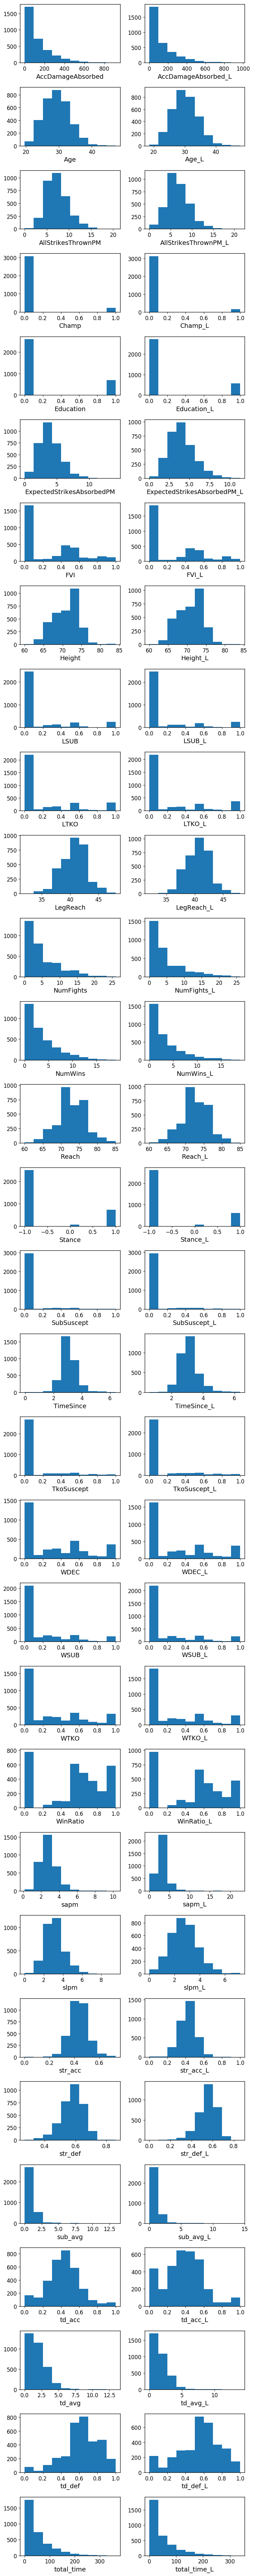

In [70]:
fig, axs = plt.subplots(nrows=31, ncols=2, figsize=(8, 80))
for i, (axi, axj) in enumerate(axs):
     axi.hist(gs[win_cols[i]])
     axi.set_xlabel(win_cols[i])
     axj.hist(gs[los_cols[i]])
     axj.set_xlabel(los_cols[i])
plt.tight_layout()

Generate all possible differences:

In [71]:
for column in win_cols:
     exec('gs[\'' + column + 'Diff\'] = gs.' + column + ' - ' + 'gs.' + column + '_L')

In [72]:
gs.describe()

,AccDamageAbsorbed,Age,AllStrikesThrownPM,Champ,Education,ExpectedStrikesAbsorbedPM,FVI,Height,LSUB,LTKO,LegReach,NumFights,NumWins,Reach,Stance,SubSuscept,TimeSince,TkoSuscept,WDEC,WSUB,WTKO,WinRatio,sapm,slpm,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,total_time,AccDamageAbsorbed_L,Age_L,AllStrikesThrownPM_L,Champ_L,Education_L,ExpectedStrikesAbsorbedPM_L,FVI_L,Height_L,LSUB_L,LTKO_L,LegReach_L,NumFights_L,NumWins_L,Reach_L,Stance_L,SubSuscept_L,TimeSince_L,TkoSuscept_L,WDEC_L,WSUB_L,WTKO_L,WinRatio_L,sapm_L,slpm_L,str_acc_L,str_def_L,sub_avg_L,td_acc_L,td_avg_L,td_def_L,total_time_L,AccDamageAbsorbedDiff,AgeDiff,AllStrikesThrownPMDiff,ChampDiff,EducationDiff,ExpectedStrikesAbsorbedPMDiff,FVIDiff,HeightDiff,LSUBDiff,LTKODiff,LegReachDiff,NumFightsDiff,NumWinsDiff,ReachDiff,StanceDiff,SubSusceptDiff,TimeSinceDiff,TkoSusceptDiff,WDECDiff,WSUBDiff,WTKODiff,WinRatioDiff,sapmDiff,slpmDiff,str_accDiff,str_defDiff,sub_avgDiff,td_accDiff,td_avgDiff,td_defDiff,total_timeDiff
count,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000
mean,132.148536,29.370169,7.298580,0.070021,0.212186,3.915482,0.262580,70.775083,0.149819,0.195038,40.567187,4.866020,3.241588,72.636139,-0.538951,0.048896,3.075741,0.096323,0.315965,0.173959,0.273641,0.539267,2.780003,3.140197,0.436411,0.579712,0.812852,0.422889,1.853428,0.622128,49.548535,130.423298,30.090444,6.721508,0.050318,0.175205,4.032258,0.231264,70.671416,0.146580,0.206923,40.515129,4.590482,2.912095,72.347817,-0.607457,0.050537,3.096816,0.107912,0.292769,0.167085,0.244702,0.477807,3.145480,2.770258,0.418975,0.548348,0.771264,0.376229,1.577830,0.548684,45.793321,1.725238,-0.720275,0.577072,0.019703,0.036981,-0.116777,0.031316,0.103668,0.003239,-0.011885,0.052058,0.275538,0.329494,0.288321,0.068506,-0.001641,-0.021075,-0.011589,0.023196,0.006874,0.028938,0.061460,-0.365477,0.369939,0.017436,0.031364,0.041588,0.046660,0.275599,0.073443,3.755214
std,144.477672,3.928070,2.477871,0.255221,0.408917,1.683757,0.304149,3.302291,0.296939,0.325763,2.283699,4.778565,3.429550,3.952129,0.830685,0.161456,0.576256,0.222808,0.344865,0.285027,0.336675,0.349074,0.919372,1.061558,0.075681,0.073210,0.858520,0.184914,1.329329,0.198769,53.288049,152.328823,4.070023,2.665527,0.218634,0.380200,1.593539,0.295336,3.186245,0.295641,0.338962,2.100591,4.970920,3.438823,3.734779,0.780030,0.161516,0.609869,0.237003,0.349788,0.288432,0.330201,0.355865,1.383684,1.089841,0.092849,0.091260,0.924233,0.223147,1.277221,0.236224,53.144784,167.403636,5.003269,3.221293,0.289140,0.548300,1.817542,0.361366,2.571155,0.411488,0.448424,1.977293,5.315473,3.583824,3.363976,1.119933,0.225077,0.792298,0.287837,0.460161,0.392366,0.434401,0.394722,1.527257,1.373534,0.113549,0.108092,1.215465,0.290613,1.860139,0.302550,59.130186
min,0.000000,19.589725,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,32.000000,0.000000,0.000000,60.000000,-1.000000,0.000000,-0.045030,0.000000,0.0000

In [73]:
gs.corr().applymap(lambda x: abs(round(x, 2)))

,AccDamageAbsorbed,Age,AllStrikesThrownPM,Champ,Education,ExpectedStrikesAbsorbedPM,FVI,Height,LSUB,LTKO,LegReach,NumFights,NumWins,Reach,Stance,SubSuscept,TimeSince,TkoSuscept,WDEC,WSUB,WTKO,WinRatio,sapm,slpm,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,total_time,AccDamageAbsorbed_L,Age_L,AllStrikesThrownPM_L,Champ_L,Education_L,ExpectedStrikesAbsorbedPM_L,FVI_L,Height_L,LSUB_L,LTKO_L,LegReach_L,NumFights_L,NumWins_L,Reach_L,Stance_L,SubSuscept_L,TimeSince_L,TkoSuscept_L,WDEC_L,WSUB_L,WTKO_L,WinRatio_L,sapm_L,slpm_L,str_acc_L,str_def_L,sub_avg_L,td_acc_L,td_avg_L,td_def_L,total_time_L,AccDamageAbsorbedDiff,AgeDiff,AllStrikesThrownPMDiff,ChampDiff,EducationDiff,ExpectedStrikesAbsorbedPMDiff,FVIDiff,HeightDiff,LSUBDiff,LTKODiff,LegReachDiff,NumFightsDiff,NumWinsDiff,ReachDiff,StanceDiff,SubSusceptDiff,TimeSinceDiff,TkoSusceptDiff,WDECDiff,WSUBDiff,WTKODiff,WinRatioDiff,sapmDiff,slpmDiff,str_accDiff,str_defDiff,sub_avgDiff,td_accDiff,td_avgDiff,td_defDiff,total_timeDiff
AccDamageAbsorbed,1.00,0.31,0.16,0.26,0.04,0.11,0.56,0.03,0.06,0.13,0.08,0.89,0.83,0.04,0.05,0.13,0.09,0.25,0.32,0.10,0.16,0.30,0.12,0.12,0.07,0.08,0.02,0.03,0.04,0.10,0.93,0.36,0.17,0.10,0.13,0.06,0.19,0.30,0.01,0.07,0.06,0.03,0.38,0.38,0.01,0.04,0.14,0.05,0.20,0.14,0.07,0.16,0.24,0.07,0.14,0.06,0.13,0.02,0.09,0.06,0.13,0.37,0.53,0.10,0.04,0.12,0.02,0.06,0.23,0.02,0.01,0.05,0.06,0.45,0.43,0.06,0.01,0.00,0.02,0.02,0.14,0.02,0.00,0.05,0.14,0.02,0.09,0.06,0.03,0.05,0.07,0.04,0.50
Age,0.31,1.00,0.18,0.17,0.14,0.01,0.19,0.11,0.02,0.19,0.13,0.39,0.34,0.10,0.06,0.01,0.18,0.23,0.07,0.01,0.15,0.08,0.09,0.13,0.12,0.03,0.09,0.04,0.03,0.05,0.36,0.17,0.22,0.00,0.12,0.06,0.17,0.15,0.20,0.01,0.11,0.19,0.22,0.21,0.19,0.02,0.02,0.06,0.19,0.05,0.01,0.14,0.11,0.05,0.06,0.09,0.03,0.03,0.05,0.02,0.10,0.19,0.11,0.61,0.14,0.07,0.07,0.14,0.04,0.10,0.02,0.05,0.05,0.14,0.12,0.10,0.05,0.01,0.08,0.02,0.01,0.00,0.01,0.03,0.01,0.15,0.01,0.00,0.04,0.07,0.04,0.11,0.15
AllStrikesThrownPM,0.16,0.18,1.00,0.00,0.02,0.28,0.04,0.09,0.02,0.06,0.12,0.02,0.04,0.09,0.06,0.01,0.05,0.01,0.05,0.13,0.11,0.08,0.46,0.87,0.24,0.27,0.26,0.05,0.31,0.25,0.04,0.13,0.02,0.22,0.02,0.01,0.91,0.06,0.14,0.02,0.00,0.14,0.07,0.07,0.15,0.03,0.04,0.01,0.04,0.05,0.00,0.02,0.05,0.20,0.18,0.04,0.13,0.07,0.01,0.01,0.06,0.08,0.02,0.13,0.59,0.02,0.01,0.54,0.01,0.05,0.03,0.04,0.01,0.04,0.03,0.06,0.02,0.04,0.03,0.04,0.00,0.09,0.07,0.02,0.09,0.53,0.13,0.07,0.13,0.02,0.21,0.12,0.04
Champ,0.26,0.17,0.00,1.00,0.06,0.03,0.20,0.06,0.00,0.13,0.03,0.35,0.43,0.09,0.03,0.03,0.09,0.19,0.04,0.00,0.14,0.21,0.11,0.06,0.15,0.06,0.01,0.19,0.04,0.08,0.35,0.17,0.16,0.01,0.26,0.10,0.02,0.15,0.06,0.01,0.07,0.03,0.22,0.27,0.07,0.01,0.01,0.08,0.16,0.05,0.01,0.14,0.18,0.08,0.05,0.06,0.06,0.00,0.08,0.04,0.08,0.20,0.07,0.01,0.01,0.68,0.03,0.01,0.05,0.01,0.01,0.04,0.00,0.11,0.16,0.03,0.02,0.01,0.00,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.05,0.01,0.01,0.06,0.01,0.01,0.13
Education,0.04,0.14,0.02,0.06,1.00,0.03,0.06,0.05,0.02,0.02,0.03,0.08,0.11,0.06,0.01,0.01,0.05,0.04,0.12,0.07,0.02,0.09,0.15,0.00,0.03,0.09,0.09,0.01,0.22,0.07,0.10,0.03,0.04,0.06,0.09,0.04,0.02,0.05,0.09,0.03,0.02,0.08,0.06,0.08,0.09,0.03,0.04,0.01,0.04,0.03,0.01,0.05,0.04,0.06,0.03,0.05,0.02,0.01,0.03,0.06,0.00,0.06,0.00,0.08,0.03,0.01,0.72,0.01,0.01,0.05,0.03,0.00,0.04,0.02,0.03,0.03,0.03,0.04,0.05,0.00,0.11,0.06,0.02,0.04,0.03,0.03,0.02,0.04,0.07,0.02,0.12,0.04,0.04
ExpectedStrikesAbsorbedPM,0.11,0.01,0.28,0.03,0.03,1.00,0.07,0.19,0.01,0.04,0.20,0.06,0.07,0.19,0.02,0.02,0.02,0.02,0.09,0.03,0.02,0.07,0.08,0.24,0.10,0.37,0.14,0.01,0.09,0.12,0.10,0.24,0.13,0.95,0.01,0.06,0.39,0.12,0.12,0.00,0.06,0.14,0.10,0.12,0.13,0.03,0.01,0.03,0.04,0.17,0.09,0.09,0.14,0.27,0.77,0.23,0.38,0.25,0.04,0.15,0.25,0.15,0.12,0.10,0.57,0.02,0.07,0.59,0.04,0.10,0.00,0.02,0.08,0.04,0.05,0.08,0.03,0.02,0.04,0.05,0.07,0.04,0.05,0.06,0.19,0.43,0.12,0.06,0.08,0.04,0.04,0.11,0.04
FVI,0.56,0.19,0.04,0.20,0.06,0.07,1.00,0.07,0.08,0.16,0.06,0.65,0.68,0.09,0.02,0.13,0.06,0.22,0.21,0.24,0.19,0.44,0.08,0.05,0.01,0.11,0.08,0.0

In [170]:
gs.to_csv('data/feature_matrix.csv')

In [74]:
shuffled = []
from random import random as rng
for index, row in gs.iterrows():
     if (rng() < 0.5):
          shuffled.append(([1] + list(row[31:62].values) + list(row[0:31].values) + list(-1 * row[62:].values)))
     else:
          shuffled.append(([0] + list(row.values)))

In [98]:
columns = ['classes'] + [col + '_1' for col in win_cols] + [col + '_2' for col in win_cols] + [col + '_12' for col in win_cols]
data = pd.DataFrame(shuffled, columns=columns)
data.describe()

,classes,AccDamageAbsorbed_1,Age_1,AllStrikesThrownPM_1,Champ_1,Education_1,ExpectedStrikesAbsorbedPM_1,FVI_1,Height_1,LSUB_1,LTKO_1,LegReach_1,NumFights_1,NumWins_1,Reach_1,Stance_1,SubSuscept_1,TimeSince_1,TkoSuscept_1,WDEC_1,WSUB_1,WTKO_1,WinRatio_1,sapm_1,slpm_1,str_acc_1,str_def_1,sub_avg_1,td_acc_1,td_avg_1,td_def_1,total_time_1,AccDamageAbsorbed_2,Age_2,AllStrikesThrownPM_2,Champ_2,Education_2,ExpectedStrikesAbsorbedPM_2,FVI_2,Height_2,LSUB_2,LTKO_2,LegReach_2,NumFights_2,NumWins_2,Reach_2,Stance_2,SubSuscept_2,TimeSince_2,TkoSuscept_2,WDEC_2,WSUB_2,WTKO_2,WinRatio_2,sapm_2,slpm_2,str_acc_2,str_def_2,sub_avg_2,td_acc_2,td_avg_2,td_def_2,total_time_2,AccDamageAbsorbed_12,Age_12,AllStrikesThrownPM_12,Champ_12,Education_12,ExpectedStrikesAbsorbedPM_12,FVI_12,Height_12,LSUB_12,LTKO_12,LegReach_12,NumFights_12,NumWins_12,Reach_12,Stance_12,SubSuscept_12,TimeSince_12,TkoSuscept_12,WDEC_12,WSUB_12,WTKO_12,WinRatio_12,sapm_12,slpm_12,str_acc_12,str_def_12,sub_avg_12,td_acc_12,td_avg_12,td_def_12,total_time_12
count,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.00000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000
mean,0.515308,132.206594,29.742978,6.997285,0.058806,0.205820,3.981803,0.249097,70.733253,0.149974,0.207501,40.546274,4.772962,3.105790,72.504475,-0.585632,0.050751,3.093835,0.103170,0.306128,0.172210,0.261819,0.514609,2.975632,2.959891,0.428330,0.563750,0.780661,0.398739,1.731546,0.587363,48.091305,130.365240,29.717635,7.022804,0.061534,0.181570,3.965937,0.244747,70.713246,0.146425,0.194459,40.536042,4.683540,3.047893,72.479481,-0.560776,0.048682,3.078721,0.101065,0.302606,0.168834,0.256524,0.502465,2.949851,2.950564,0.427057,0.56431,0.803456,0.400379,1.699712,0.583450,47.250551,1.841354,0.025342,-0.025519,-0.002728,0.024250,0.015866,0.004351,0.020006,0.003549,0.013042,0.010232,0.089421,0.057896,0.024995,-0.024856,0.002069,0.015114,0.002106,0.003521,0.003376,0.005295,0.012145,0.025781,0.009327,0.001273,-0.000561,-0.022795,-0.001640,0.031834,0.003913,0.840755
std,0.499841,149.025406,4.010294,2.523361,0.235296,0.404361,1.678406,0.301103,3.223683,0.299919,0.335709,2.176576,4.936128,3.442329,3.835294,0.798072,0.165585,0.575901,0.231717,0.348011,0.288187,0.333855,0.352739,1.245386,1.079517,0.084901,0.082417,0.848651,0.202755,1.299749,0.219979,54.063298,147.882012,4.021383,2.654009,0.240343,0.385548,1.601267,0.299245,3.266546,0.292615,0.329093,2.211693,4.818023,3.433702,3.860011,0.814619,0.157277,0.610293,0.228442,0.347037,0.285305,0.333660,0.354800,1.129298,1.103498,0.085391,0.08595,0.933628,0.209680,1.321568,0.222734,52.419877,167.402398,5.054800,3.272490,0.289798,0.549011,1.821222,0.362694,2.573167,0.411485,0.448392,1.977952,5.321861,3.598478,3.376220,1.121752,0.225074,0.792434,0.288062,0.460732,0.392412,0.435332,0.399295,1.570179,1.422465,0.114873,0.112550,1.215962,0.294331,1.880181,0.311315,59.243377
min,0.000000,0.000000,19.589725,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,32.00000

In [99]:
sorted(data.corr().applymap(lambda x: abs(round(x, 2))).values.flatten().tolist(), reverse=True)[:15]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [100]:
data = data.sample(data.shape[0], replace=False, axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 849 to 2866
Data columns (total 94 columns):
classes                         3299 non-null int64
AccDamageAbsorbed_1             3299 non-null float64
Age_1                           3299 non-null float64
AllStrikesThrownPM_1            3299 non-null float64
Champ_1                         3299 non-null float64
Education_1                     3299 non-null float64
ExpectedStrikesAbsorbedPM_1     3299 non-null float64
FVI_1                           3299 non-null float64
Height_1                        3299 non-null float64
LSUB_1                          3299 non-null float64
LTKO_1                          3299 non-null float64
LegReach_1                      3299 non-null float64
NumFights_1                     3299 non-null float64
NumWins_1                       3299 non-null float64
Reach_1                         3299 non-null float64
Stance_1                        3299 non-null float64
SubSuscept_1                 

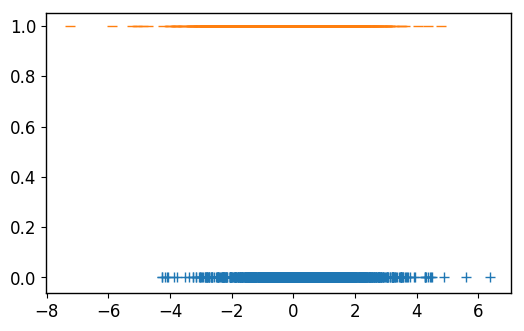

In [116]:
plt.scatter(data[data.classes==0].slpm_12, data[data.classes==0].classes, marker='+')
plt.scatter(data[data.classes==1].slpm_12, data[data.classes==1].classes, marker='_')

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.linear_model import LogisticRegression

In [118]:
def get_score(features):
     X = data[features].values
     y = data.classes.values
     stdsc = StandardScaler()
     StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
     param_grid = dict(C=np.logspace(-4, 1, base=10, num=25), penalty=['l1', 'l2'])
     test_accuracies = []
     brier_scores = []
     for i in range(10):
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
          clf = LogisticRegression()
          grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
          X_std = stdsc.fit_transform(X_train)
          grid.fit(X_std, y_train)
          # predict test labels
          X_std_test = stdsc.transform(X_test)
          y_test_pred = grid.predict(X_std_test)
          y_test_prob = grid.predict_proba(X_std_test)[:,1]
          test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
          test_accuracies.append(test_accuracy)
          brier_scores.append(metrics.brier_score_loss(y_test, y_test_prob))
          return np.array(test_accuracies).mean(), np.array(brier_scores).mean()

In [142]:
single_logistic = []
for col in data.columns[63:]:
     acc, bri = get_score([col])
     single_logistic.append((acc, bri, col))

In [152]:
tmp = sorted(single_logistic, reverse=True)
tmp = pd.DataFrame(tmp, columns=['Accuracy', 'Brier Score', 'Feature'])
tmp.index = range(1, 32)
tmp.Accuracy = tmp.Accuracy.apply(lambda x: round(x, 2))
tmp['Brier Score'] = tmp['Brier Score'].apply(lambda x: round(x, 2))
tmp[['Feature', 'Accuracy', 'Brier Score']].to_latex('report/prediction/single_feature_logistic_RAW.tex')

In [111]:
get_score(['Age_1', 'Reach_1', 'Age_2', 'Reach_2'])

0.55353535353535355

In [110]:
get_score(['Age_12', 'Reach_12'])

0.5636363636363636

In [158]:
get_score(['Age_12', 'Reach_12', 'Age_1', 'Reach_1'])

(0.56262626262626259, 0.24377244228278047)

In [160]:
get_score(['Age_1', 'Reach_1', 'Stance_1', 'Age_2', 'Reach_2', 'Stance_2'])

(0.5696969696969697, 0.24351066935803639)

In [159]:
get_score(['Age_12', 'Reach_12', 'Stance_12'])

(0.57373737373737377, 0.24802811906069078)

In [156]:
get_score(['Age_12', 'Reach_12', 'Champ_12'])

(0.57373737373737377, 0.24908205609352516)

In [155]:
get_score(['Age_12', 'Reach_12', 'Champ_12', 'Education_12'])

(0.58686868686868687, 0.24835844140751676)

In [107]:
get_score(['Age_1', 'Reach_1', 'Stance_1', 'Age_2', 'Reach_2', 'Stance_2'])

0.56767676767676767

In [112]:
get_score(['Age_1', 'Reach_1', 'Stance_1', 'slpm_1', 'Age_2', 'Reach_2', 'Stance_2', 'slpm_2'])

0.62828282828282833

In [113]:
get_score(['Age_12', 'Reach_12', 'Stance_12', 'slpm_12'])

0.62525252525252528

In [161]:
get_score(['Age_1', 'Reach_1', 'Stance_1', 'slpm_1', 'Age_2', 'Reach_2', 'Stance_2', 'slpm_2'])

(0.62828282828282833, 0.22575151878840624)

In [162]:
get_score(data.columns[1:])

(0.69393939393939397, 0.19776886234864804)

In [166]:
get_score(data.columns[1:32])

(0.66060606060606064, 0.21594459435830668)

In [167]:
get_score(data.columns[32:63])

(0.6262626262626263, 0.22407204403660072)

In [168]:
get_score(data.columns[63:])

(0.68888888888888888, 0.19753605186830117)

### Binary decision trees

In [163]:
from sklearn.tree import DecisionTreeClassifier
# different scoring metrics: http://scikit-learn.org/stable/modules/model_evaluation.html

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(max_depth=range(1, 10), criterion=['gini', 'entropy'], splitter=['best', 'random'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = DecisionTreeClassifier(random_state=0)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     y_test_prob = grid.predict_proba(X_test)[:,1]
     test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy, metrics.brier_score_loss(y_test, y_test_prob)

0 0.62364660026 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 5} 0.606060606061 0.321677996307
1 0.639670853183 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4} 0.633333333333 0.228504527199
2 0.628410567345 {'splitter': 'random', 'criterion': 'gini', 'max_depth': 4} 0.617171717172 0.227326353711
3 0.618449545258 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 6} 0.639393939394 0.281461475796
4 0.636206149848 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4} 0.616161616162 0.234381823595
5 0.62494586401 {'splitter': 'random', 'criterion': 'entropy', 'max_depth': 5} 0.607070707071 0.238433379391
6 0.620181896925 {'splitter': 'random', 'criterion': 'gini', 'max_depth': 3} 0.642424242424 0.247721583716
7 0.625378951927 {'splitter': 'random', 'criterion': 'gini', 'max_depth': 7} 0.607070707071 0.326650404758
8 0.637505413599 {'splitter': 'random', 'criterion': 'entropy', 'max_depth': 5} 0.611111111111 0.255451562396
9 0.621048072759 {'splitter': 'random', '

In [164]:
np.array(test_accuracies).mean()

0.61989898989898973

In [ ]:
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), gs.columns[indices], rotation=0)
plt.xlabel('Decision tree importance')

Write out the optimal tree to graph file:

In [ ]:
# http://webgraphviz.com (paste contents of file here)
#from sklearn import tree
#fn = ['stance1', 'age1', 'stance2', 'age2']
#cn = ['fighter1 wins', 'fighter2 wins']
#clf.set_params(**grid.best_params_).fit(X_train, y_train)
#tree.export_graphviz(clf, out_file='tree.dot', feature_names=fn, class_names=cn)

In [ ]:
# uncomment below to see log
#grid.cv_results_

### Evaluation of the classifer

In [ ]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
confmat

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
     for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')

### ROC curve

In [ ]:
# store the predicted probabilities for class 1 
y_pred_prob = grid.predict_proba(X_test)[:,1]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [ ]:
metrics.roc_auc_score(y_test, y_pred_prob)

### Accuracy is maximized at threshold is 1/2 as implied by scoring choice

In [ ]:
thresholds = np.arange(0, 1.05, 0.05)
plt.plot(thresholds, [metrics.accuracy_score(y_test, pd.Series(y_pred_prob).apply(lambda x: 0 if x < threshold else 1)) for threshold in thresholds])

### Precision vs recall

In [ ]:
metrics.recall_score(y_test, y_test_pred)

In [ ]:
metrics.precision_score(y_test, y_test_pred)

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob, pos_label=1)
plt.plot(recall, precision)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')

     pre = tp / (tp + fp)
     rec = tp / (tp + fn)
When precision is high we only predict 1 when we are very confident. This means we mostly predict 0 and are frequenty wrong (many FN) which means low recall. When we aggressively predict 1, we have many false positive which drops precision. Recall increases since there are few false negatives.

# Other models

### Neural nets

In [ ]:
from sklearn.neural_network import MLPClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(alpha=np.logspace(-4, 0, base=10, num=15))

test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Random Forest

0 0.666089216111 {} 0.678787878788
1 0.666089216111 {} 0.662626262626
2 0.677349501949 {} 0.669696969697
3 0.642702468601 {} 0.70101010101
4 0.677349501949 {} 0.680808080808
5 0.682113469034 {} 0.667676767677
6 0.674317886531 {} 0.665656565657
7 0.669553919446 {} 0.661616161616
8 0.670420095279 {} 0.674747474747
9 0.67301862278 {} 0.672727272727
0.673535353535 0.660892161109


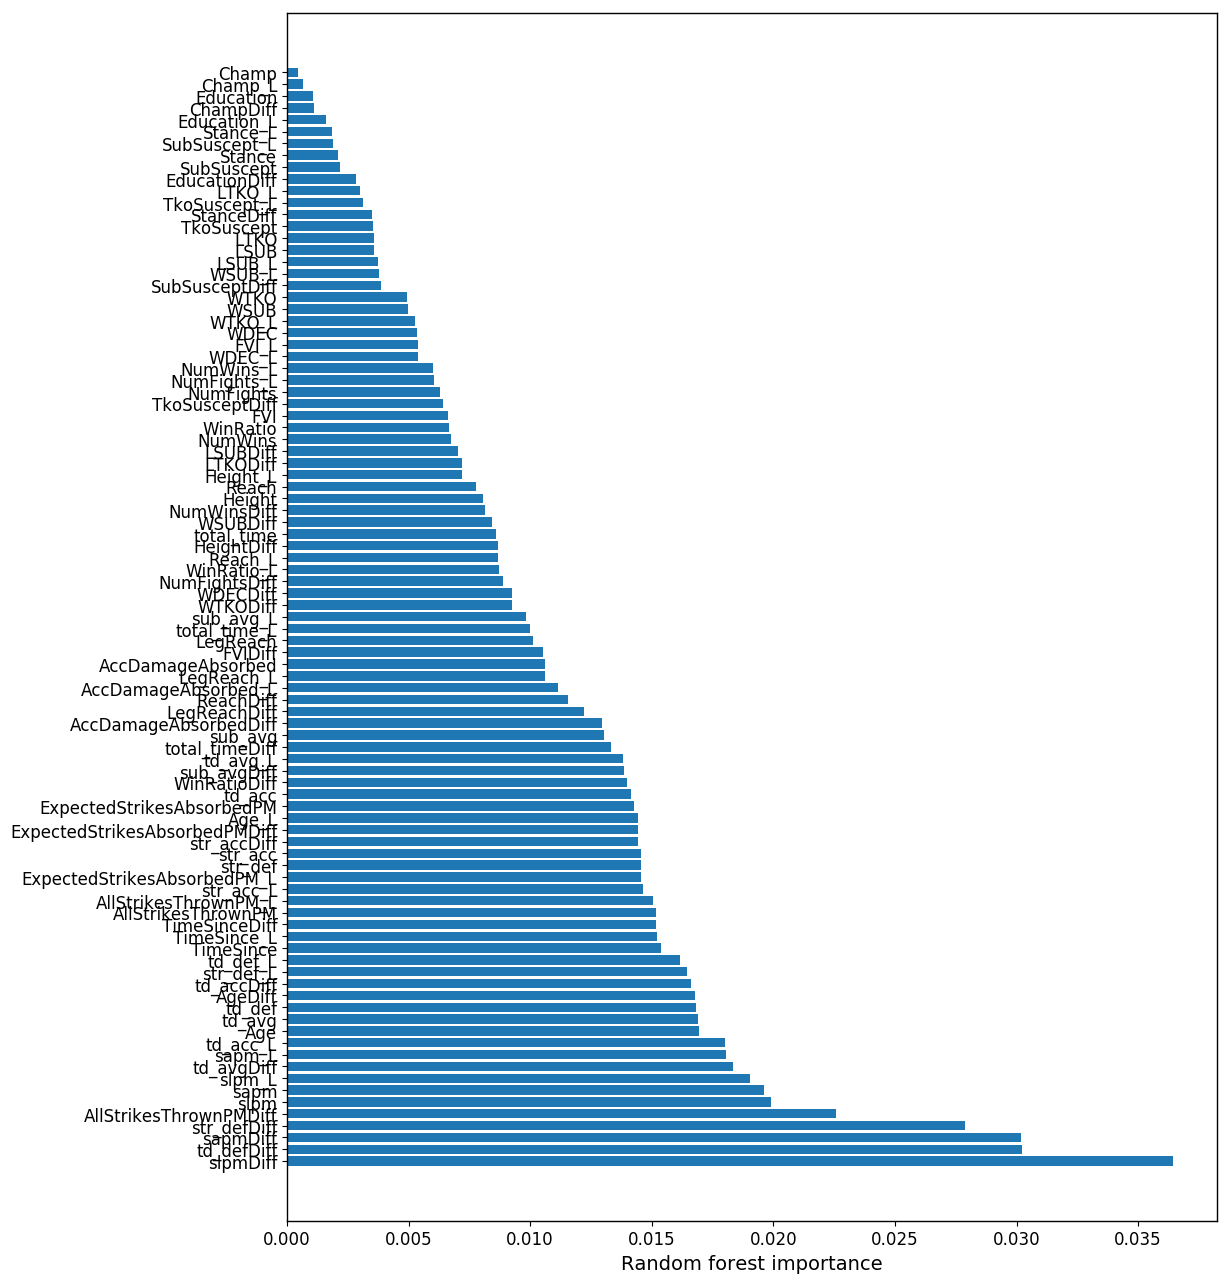

In [165]:
from sklearn.ensemble import RandomForestClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(criterion=['gini', 'entropy'], bootstrap=[True, False])

param_grid = {}

test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', bootstrap=True, oob_score=True)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy, grid.best_estimator_.oob_score_
     
print np.array(test_accuracies).mean()
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(10,18))
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), gs.columns[indices], rotation=0)
plt.xlabel('Random forest importance')

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(C=np.logspace(-4, 1, base=10, num=25), penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = LogisticRegression()
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     X_std = stdsc.fit_transform(X_train)
     X_std_lda = tsne.fit_transform(X_std, y_train)
     print X_std_lda.shape, X_std.shape
     grid.fit(X_std_lda, y_train)
     # predict test labels
     X_std_l = 
     y_test_pred = grid.predict(X_std_lda_test)
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
plt.scatter(X_std_lda[y_train==1, 0], X_std_lda[y_train==1, 1])

In [ ]:
np.array(test_accuracies).mean()

In [ ]:
grid.best_estimator_.coef_

In [ ]:
grid.best_estimator_.intercept_

In [ ]:
coeffs = []
c_values = np.logspace(-3, 0, base=10, num=25)
for c in c_values:
     clf = LogisticRegression(C=c, penalty='l1')
     clf.fit(stdsc.fit_transform(X_train), y_train)
     coeffs.append(clf.coef_[0])
cf = pd.DataFrame(coeffs, columns=gs.columns)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(cf.shape[1]):
     if (i > 7): plt.semilogx(c_values, cf.iloc[:,i], label=cf.columns[i])
     else: plt.semilogx(c_values, cf.iloc[:,i], label=cf.columns[i], ls='dashed')
plt.axvline(x=0.08, ymin=0, ymax=1, color='k', ls=':')
plt.ylim(-0.6, 0.6)
plt.xlabel('Inverse Regularization Parameter, C')
plt.ylabel('Coefficient')
#plt.legend(loc=(1.05, 0.2))

### AdaBoost

from sklearn.ensemble import AdaBoostClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(learning_rate=np.logspace(-4, 0, base=10, num=5),
                  n_estimators=[25, 50, 100],
                  base_estimator__max_depth=[1, 2, 3])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     tree = DecisionTreeClassifier(criterion='entropy')
     clf = AdaBoostClassifier(tree)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### KNN

from sklearn.neighbors import KNeighborsClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
# p=2 with minkowski is euclidean so omitted below
param_grid = [dict(n_neighbors=range(10, 110, 10), weights=['uniform', 'distance'],
              metric=['minkowski'], p=[1, 3, 4]),
              dict(n_neighbors=range(10, 110, 10), weights=['uniform', 'distance'],
              metric=['chebyshev', 'euclidean'])]
param_grid = [dict(n_neighbors=range(7, 35, 2), weights=['uniform', 'distance'], metric=['chebyshev', 'euclidean'])]
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = KNeighborsClassifier()
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Support Vector Classifier

from sklearn.svm import SVC
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = [dict(kernel=['linear'],
                   C=np.logspace(-3, 3, base=10, num=15),
                   shrinking=[True, False])]
param_grid = [dict(kernel=['linear'], C=np.logspace(-3, 3, base=10, num=7))]
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = SVC(probability=True)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(pca.fit_transform(stdsc.fit_transform(X_train)), y_train)
     # predict test labels
     y_test_pred = grid.predict(pca.transform(stdsc.transform(X_test)))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Bagged Logistic Regression

#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(n_estimators=[25, 50],
                  bootstrap_features=[True, False],
                  base_estimator__C=np.logspace(-3, 3, base=10, num=15),
                  base_estimator__penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     lr = LogisticRegression()
     clf = BaggingClassifier(base_estimator=lr)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()